-----
<center>
<h1 style="font-size: 50px; font-family: serif;">Handwritten signature recognition using Deep Learning
</h1>
</center>

---

---
# 1. Import Modules 
<span id="Importmodules"></span>

---

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib
import tensorflow as tf
import os
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load and preprocess the dataset
train_dir = 'split_data/train'
test_dir = 'split_data/test'

In [4]:
# ImageDataGenerator for loading and augmenting images
datagen = ImageDataGenerator(rescale=1./255)

---
# 2. Load images with augmentation
<span id="Importmodules"></span>

---

In [5]:
# Load images from the training directory
train_data_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Load images from the testing directory
test_data_gen = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Step 1: Load MobileNet as a feature extractor
base_model = MobileNet(weights='imagenet', include_top=False)

# Add a Global Average Pooling layer to extract features
x = base_model.output
x = GlobalAveragePooling2D()(x)
feature_extractor = Model(inputs=base_model.input, outputs=x)

# Freeze the layers of MobileNet to use it as a feature extractor
for layer in base_model.layers:
    layer.trainable = False

# Step 2: Extract features for training and testing data
def extract_features(data_generator):
    features = []
    labels = []
    
    # Loop through batches of images and extract features
    for images, batch_labels in data_generator:
        # Extract features from the MobileNet model
        feature_batch = feature_extractor.predict(images)
        features.append(feature_batch)
        labels.append(batch_labels)
        
        # If we have enough data, stop
        if len(features) * data_generator.batch_size >= data_generator.samples:
            break
    
    # Convert to numpy arrays
    features = np.vstack(features)
    labels = np.vstack(labels)
    return features, labels

# Extract features for train data
X_train_features, y_train_labels = extract_features(train_data_gen)

# Extract features for test data
X_test_features, y_test_labels = extract_features(test_data_gen)

# Step 3: Save the extracted features to .joblib files
joblib.dump((X_train_features, y_train_labels), 'train.joblib')
joblib.dump((X_test_features, y_test_labels), 'test.joblib')

# Step 4: Split the training data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_features, y_train_labels, test_size=0.2, random_state=42
)

# Optionally, save the split data to .joblib files
joblib.dump((X_train, y_train), 'train_split.joblib')
joblib.dump((X_val, y_val), 'val_split.joblib')

# Saved in 'train.joblib' and 'test.joblib'
print("Features extracted and saved to 'train.joblib' and 'test.joblib'.")

Found 1919 images belonging to 2 classes.
Found 481 images belonging to 2 classes.


1/1 [==============================] - 0s 58ms/step
Features extracted and saved to 'train.joblib' and 'test.joblib'.


---
# 3. Mobilenet Model
<span id="Importmodules"></span>

---

In [8]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input


# Load the features extracted previously
X_train_features, y_train_labels = joblib.load('train_split.joblib')
X_val, y_val = joblib.load('val_split.joblib')
X_test_features, y_test_labels = joblib.load('test.joblib')

# If the labels are not already one-hot encoded, we can one-hot encode them
num_classes = y_train_labels.shape[1]  

input_shape = X_train_features.shape[1]  # The number of features per sample (1024 in this case)

# Define the model for classification
input_layer = Input(shape=(input_shape,))  # This is the shape of the features (1024,)
x = Dropout(0.5)(input_layer)  # Dropout to reduce overfitting
x = Dense(1024, activation='relu')(x)  # Fully connected layer with ReLU activation
x = Dropout(0.5)(x)  # Another Dropout layer
output_layer = Dense(num_classes, activation='softmax')(x)  # Output layer with softmax for multi-class classification

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_features, y_train_labels, 
                    epochs=10, batch_size=32, 
                    validation_data=(X_val, y_val))


Epoch 1/10
48/48 [==============================] - 2s 25ms/step - loss: 0.4481 - accuracy: 0.8130 - val_loss: 0.0988 - val_accuracy: 0.9740
Epoch 2/10
48/48 [==============================] - 1s 21ms/step - loss: 0.1987 - accuracy: 0.9218 - val_loss: 0.0580 - val_accuracy: 0.9844
Epoch 3/10
48/48 [==============================] - 1s 21ms/step - loss: 0.1579 - accuracy: 0.9368 - val_loss: 0.0770 - val_accuracy: 0.9818
Epoch 4/10
48/48 [==============================] - 1s 21ms/step - loss: 0.1695 - accuracy: 0.9329 - val_loss: 0.0466 - val_accuracy: 0.9870
Epoch 5/10
48/48 [==============================] - 1s 21ms/step - loss: 0.1226 - accuracy: 0.9524 - val_loss: 0.0602 - val_accuracy: 0.9818
Epoch 6/10
48/48 [==============================] - 1s 21ms/step - loss: 0.1279 - accuracy: 0.9505 - val_loss: 0.0528 - val_accuracy: 0.9922
Epoch 7/10
48/48 [==============================] - 1s 21ms/step - loss: 0.0764 - accuracy: 0.9700 - val_loss: 0.0411 - val_accuracy: 0.9844
Epoch 8/10
48

In [9]:
# Save the trained model
model.save('mobilenet_v2_classifier_model.h5')

---
# 4. Plot training and validation accuracy
<span id="Importmodules"></span>

---

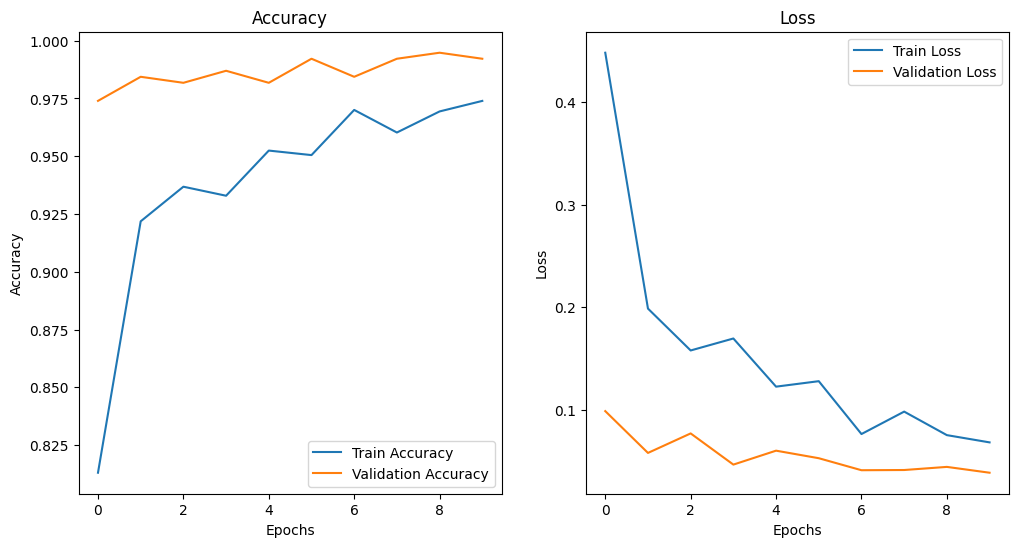

In [10]:
# Plot accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [11]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_features, y_test_labels, verbose=1)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Make predictions on the test set
y_pred = model.predict(X_test_features)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_labels, axis=1)

16/16 [==============================] - 0s 3ms/step - loss: 0.0285 - accuracy: 0.9938
Test accuracy: 0.9938
Test loss: 0.0285
16/16 [==============================] - 0s 2ms/step


---
# 5. Confusion Matrix and Classification Report
<span id="Importmodules"></span>

---

Confusion Matrix:
[[240   1]
 [  2 238]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       241
           1       1.00      0.99      0.99       240

    accuracy                           0.99       481
   macro avg       0.99      0.99      0.99       481
weighted avg       0.99      0.99      0.99       481



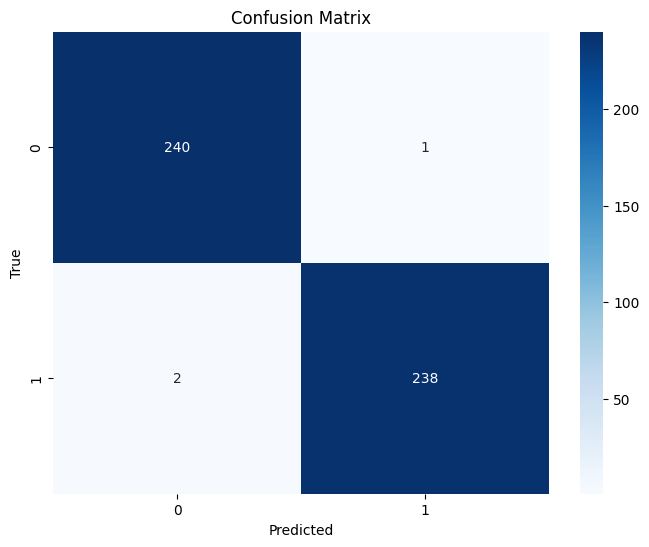

In [12]:

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:")
print(class_report)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

---
# 10. CNN Model
<span id="Importmodules"></span>

---

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import joblib
import numpy as np

# Load the features and labels for train, validation, and test sets
X_train_features, y_train_labels = joblib.load('train_split.joblib')
X_val, y_val = joblib.load('val_split.joblib')
X_test_features, y_test_labels = joblib.load('test.joblib')

# Print the shape of the features to confirm
print(f"X_train_features shape: {X_train_features.shape}")
print(f"y_train_labels shape: {y_train_labels.shape}")
print(f"X_test_features shape: {X_test_features.shape}")
print(f"y_test_labels shape: {y_test_labels.shape}")

# Define the fully connected model for the extracted features
model = Sequential()

# Input layer (feature vectors of size 1024)
model.add(Dense(1024, activation='relu', input_shape=(X_train_features.shape[1],)))
model.add(Dropout(0.5))  # Dropout to reduce overfitting

# Hidden layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Output layer (number of classes)
model.add(Dense(y_train_labels.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_features, y_train_labels, 
                    epochs=5, batch_size=32, 
                    validation_data=(X_val, y_val))

X_train_features shape: (1535, 1024)
y_train_labels shape: (1535, 2)
X_test_features shape: (481, 1024)
y_test_labels shape: (481, 2)
Epoch 1/5
48/48 [==============================] - 3s 36ms/step - loss: 0.5703 - accuracy: 0.7466 - val_loss: 0.1712 - val_accuracy: 0.9271
Epoch 2/5
48/48 [==============================] - 2s 32ms/step - loss: 0.1603 - accuracy: 0.9349 - val_loss: 0.0523 - val_accuracy: 0.9870
Epoch 3/5
48/48 [==============================] - 2s 32ms/step - loss: 0.0818 - accuracy: 0.9681 - val_loss: 0.0594 - val_accuracy: 0.9844
Epoch 4/5
48/48 [==============================] - 2s 33ms/step - loss: 0.0570 - accuracy: 0.9733 - val_loss: 0.0420 - val_accuracy: 0.9896
Epoch 5/5
48/48 [==============================] - 2s 32ms/step - loss: 0.0491 - accuracy: 0.9818 - val_loss: 0.0498 - val_accuracy: 0.9896


In [16]:
# Save the model
model.save('cnn_model.h5')

In [17]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_features, y_test_labels)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

16/16 [==============================] - 0s 4ms/step - loss: 0.0350 - accuracy: 0.9938
Test accuracy: 0.9938
Test loss: 0.0350


---
# 11. Plot training and validation accuracy
<span id="Importmodules"></span>

---

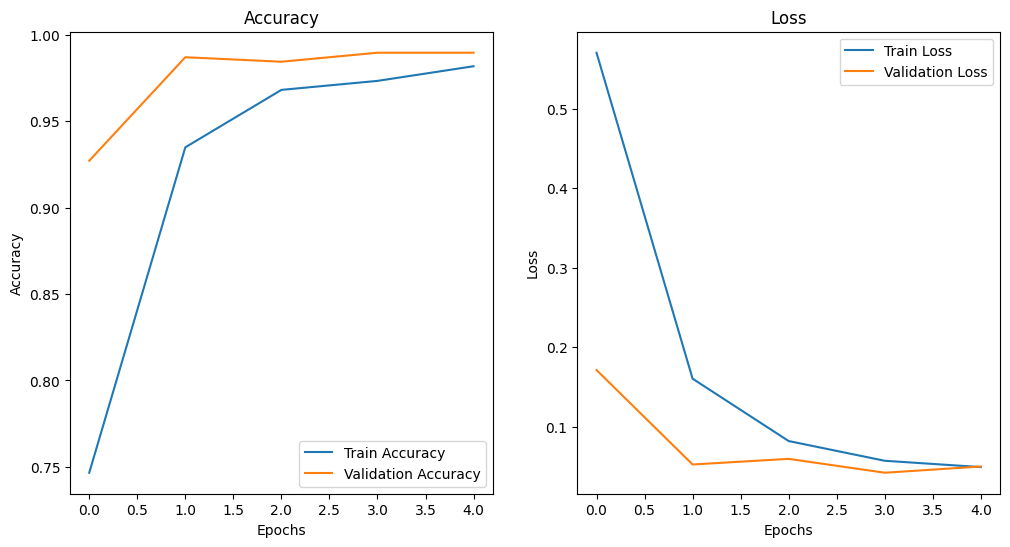

In [18]:
# Plot accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

---
# 12. Confusion Matrix and Classification Report
<span id="Importmodules"></span>

---

16/16 [==============================] - 0s 5ms/step
Confusion Matrix:
[[239   2]
 [  1 239]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       241
           1       0.99      1.00      0.99       240

    accuracy                           0.99       481
   macro avg       0.99      0.99      0.99       481
weighted avg       0.99      0.99      0.99       481



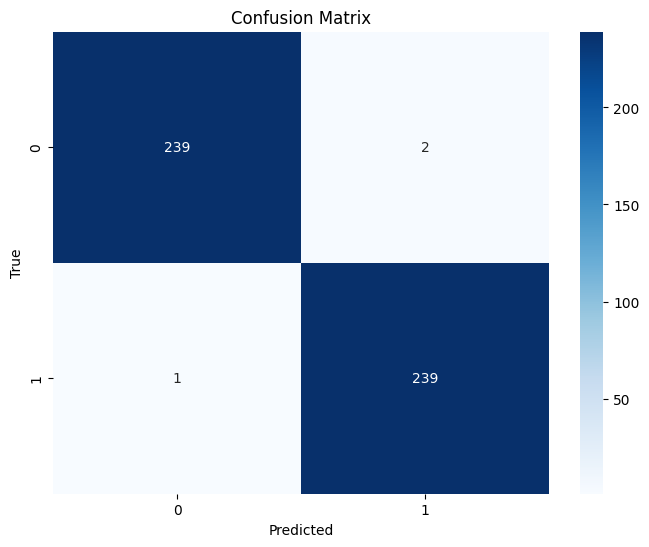

In [19]:
# Make predictions on the test set
y_pred = model.predict(X_test_features)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_labels, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:")
print(class_report)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

---
# 13. AlexNet Model
<span id="Importmodules"></span>

---

In [21]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import seaborn as sns

# Load the features extracted previously
X_train_features, y_train_labels = joblib.load('train_split.joblib')
X_val, y_val = joblib.load('val_split.joblib')
X_test_features, y_test_labels = joblib.load('test.joblib')

# If the labels are not already one-hot encoded, we can one-hot encode them
num_classes = y_train_labels.shape[1]  # Number of output classes (e.g., 2)

# Define the model for classification (using dense layers only)
input_shape = X_train_features.shape[1]  # 1024, since your features are flattened

input_layer = Input(shape=(input_shape,))  # Input layer for flattened features
x = Dropout(0.5)(input_layer)  # Dropout layer for regularization
x = Dense(1024, activation='relu')(x)  # Fully connected layer with 1024 neurons
x = Dropout(0.5)(x)  # Dropout layer
x = Dense(1024, activation='relu')(x)  # Another fully connected layer with 1024 neurons
x = Dropout(0.5)(x)  # Dropout layer for regularization
output_layer = Dense(num_classes, activation='softmax')(x)  # Output layer with softmax

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_features, y_train_labels, 
                    epochs=10, batch_size=32, 
                    validation_data=(X_val, y_val))


Epoch 1/10
48/48 [==============================] - 3s 41ms/step - loss: 0.6821 - accuracy: 0.7557 - val_loss: 0.1573 - val_accuracy: 0.9427
Epoch 2/10
48/48 [==============================] - 2s 38ms/step - loss: 0.2647 - accuracy: 0.8919 - val_loss: 0.0887 - val_accuracy: 0.9740
Epoch 3/10
48/48 [==============================] - 2s 38ms/step - loss: 0.2172 - accuracy: 0.9179 - val_loss: 0.0653 - val_accuracy: 0.9818
Epoch 4/10
48/48 [==============================] - 2s 38ms/step - loss: 0.1476 - accuracy: 0.9440 - val_loss: 0.0527 - val_accuracy: 0.9896
Epoch 5/10
48/48 [==============================] - 2s 38ms/step - loss: 0.1496 - accuracy: 0.9427 - val_loss: 0.0497 - val_accuracy: 0.9818
Epoch 6/10
48/48 [==============================] - 2s 40ms/step - loss: 0.1034 - accuracy: 0.9570 - val_loss: 0.0347 - val_accuracy: 0.9896
Epoch 7/10
48/48 [==============================] - 2s 39ms/step - loss: 0.1188 - accuracy: 0.9544 - val_loss: 0.0456 - val_accuracy: 0.9870
Epoch 8/10
48

In [22]:
# Save the model
model.save('alexnet_model.h5')

In [23]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_features, y_test_labels)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

16/16 [==============================] - 0s 4ms/step - loss: 0.0237 - accuracy: 0.9958
Test accuracy: 0.9958
Test loss: 0.0237


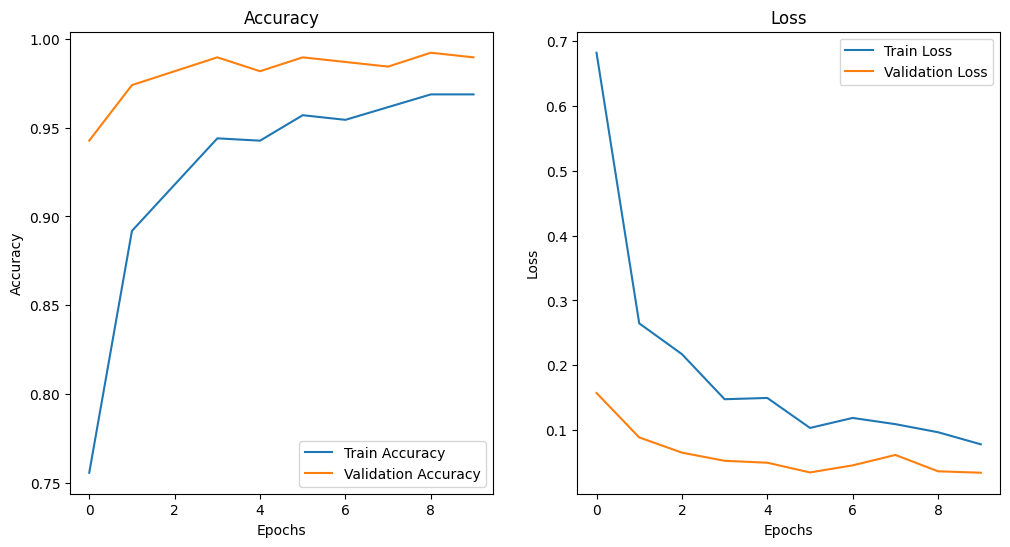

In [24]:
# Plot accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

16/16 [==============================] - 0s 4ms/step
Confusion Matrix:
[[240   1]
 [  1 239]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       241
           1       1.00      1.00      1.00       240

    accuracy                           1.00       481
   macro avg       1.00      1.00      1.00       481
weighted avg       1.00      1.00      1.00       481



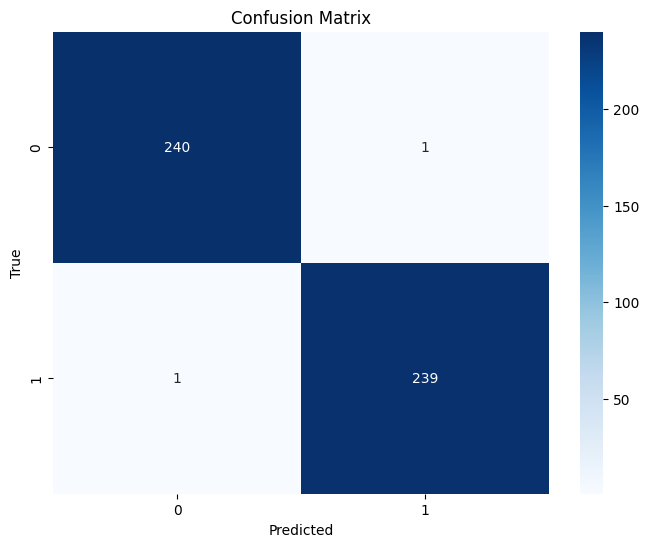

In [25]:
# Make predictions on the test set
y_pred = model.predict(X_test_features)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_labels, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:")
print(class_report)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [26]:
# Extract class names from the training data generator
class_indices = train_data_gen.class_indices  # This gives a dictionary mapping class names to indices
class_names = [key for key, _ in sorted(class_indices.items(), key=lambda item: item[1])]

print("Class Names:", class_names)


Class Names: ['FORGERY_ALL', 'REAL_ALL']
